In [1]:
import pandas as pd # data handling (tables, CSV files, datasets)
import numpy as np  # used for mathematical operations and arrays.
import matplotlib.pyplot as plt # Used to plot graphs and charts.
%matplotlib inline 
# Ensures graphs appear inside the notebook, not in a separate window.
from matplotlib.pylab import rcParams # rcParams stands for: Runtime Configuration Parameters : Way to setup your diagram
rcParams['figure.figsize']=20,10  #: figure width is 20 and height is 10
from keras.models import Sequential # Sequential is used to build neural networks layer-by-layer.
from keras.layers import LSTM,Dropout,Dense # Dropout : Prevents overfitting (model memorizing data) , Dense : Fully connected layer
from sklearn.preprocessing import MinMaxScaler #Scales data between 0 and 1 : it is done becoz neural network works better with normalized data

In [7]:
df = pd.read_csv(r"C:\Users\SUNYLoaner\Desktop\Code\ML Projects\SPS\NSE\NSE-DATA.csv") # reads the csv file in location
df.head() # shows first 5 row of columns


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


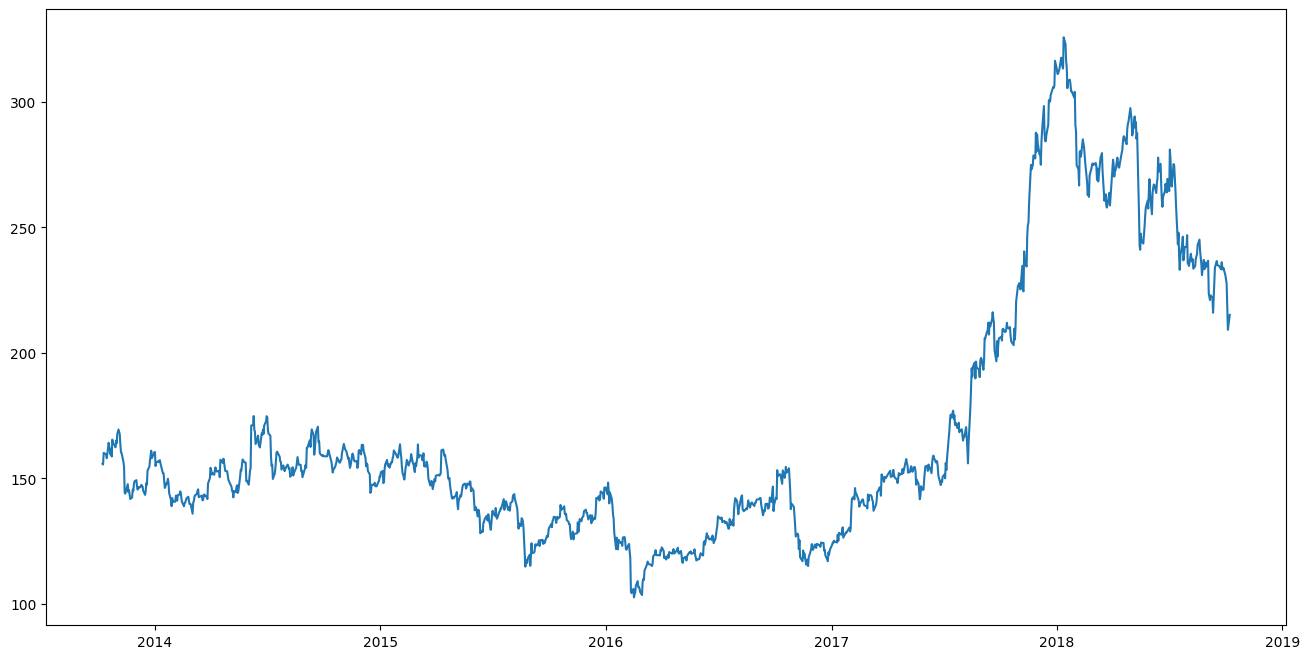

In [8]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d") # pd.to_datetime() = Converts string → datetime
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [10]:
data = df.sort_index()
new_dataset = pd.DataFrame(index=range(len(data)), columns=['Date','Close'])

for i in range(len(data)):
    new_dataset.loc[i, "Date"] = data["Date"].iloc[i]
    new_dataset.loc[i, "Close"] = data["Close"].iloc[i]


In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# -----------------------------
# A1) Make Date handling safe
# -----------------------------
df2 = df.copy()

# If index is named "Date" AND there is also a "Date" column, rename index to avoid conflict
if df2.index.name == "Date" and "Date" in df2.columns:
    df2.index.name = "Date_index"

# Bring index into a column (safe reset)
df2 = df2.reset_index()

# If Date column doesn't exist but Date_index does, rename it to Date
if "Date" not in df2.columns and "Date_index" in df2.columns:
    df2 = df2.rename(columns={"Date_index": "Date"})

# -----------------------------
# A2) Keep only Date + Close and clean
# -----------------------------
new_dataset = df2[["Date", "Close"]].copy()

new_dataset["Date"] = pd.to_datetime(new_dataset["Date"], errors="coerce")
new_dataset["Close"] = pd.to_numeric(new_dataset["Close"], errors="coerce")

# Drop bad rows + sort by time
new_dataset = new_dataset.dropna(subset=["Date", "Close"]).sort_values("Date")

# Set Date as index (time-series)
new_dataset = new_dataset.set_index("Date")

# -----------------------------
# A3) Train/Valid Split
# -----------------------------
close_values = new_dataset[["Close"]].values  # 2D array required by scaler

train_size = 987
train_data = close_values[:train_size]
valid_data = close_values[train_size:]

# -----------------------------
# A4) Normalize (fit ONLY on train)
# -----------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
valid_scaled = scaler.transform(valid_data)

# -----------------------------
# A5) Create LSTM sequences (TRAIN + VALIDATION)
# -----------------------------
lookback = 60

# ---- TRAIN sequences ----
X_train = np.array([train_scaled[i-lookback:i, 0] for i in range(lookback, len(train_scaled))])
y_train = np.array([train_scaled[i, 0] for i in range(lookback, len(train_scaled))])
X_train = X_train.reshape(X_train.shape[0], lookback, 1)

# ---- VALIDATION sequences ----
# We prepend the last 60 training points so the first validation window has history
valid_input = np.vstack([train_scaled[-lookback:], valid_scaled])

X_valid = np.array([valid_input[i-lookback:i, 0] for i in range(lookback, len(valid_input))])
y_valid = np.array([valid_input[i, 0] for i in range(lookback, len(valid_input))])
X_valid = X_valid.reshape(X_valid.shape[0], lookback, 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: (927, 60, 1)
y_train shape: (927,)
X_valid shape: (248, 60, 1)
y_valid shape: (248,)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

lstm_model = Sequential()
lstm_model.add(Input(shape=(lookback, 1)))

lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(1))

lstm_model.compile(loss="mean_squared_error", optimizer="adam")

# ✅ monitor val_loss
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

# ✅ monitor val_loss
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# ✅ pass validation_data
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=200,
    batch_size=32,
    verbose=2,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/200
29/29 - 3s - 90ms/step - loss: 0.0204 - val_loss: 0.0438 - learning_rate: 0.0010
Epoch 2/200
29/29 - 1s - 48ms/step - loss: 0.0054 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 3/200
29/29 - 1s - 39ms/step - loss: 0.0044 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 4/200
29/29 - 1s - 49ms/step - loss: 0.0044 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 5/200
29/29 - 2s - 65ms/step - loss: 0.0040 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 6/200
29/29 - 2s - 57ms/step - loss: 0.0037 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 7/200
29/29 - 2s - 65ms/step - loss: 0.0034 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 8/200
29/29 - 2s - 70ms/step - loss: 0.0037 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 9/200

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
29/29 - 2s - 62ms/step - loss: 0.0038 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 10/200
29/29 - 2s - 53ms/step - loss: 0.0034 - val_loss: 0.0113 - learning_rate:

In [42]:
# -----------------------------
# Step 7: Make predictions on validation data
# -----------------------------

# Predict (scaled values)
predicted_closing_price_scaled = lstm_model.predict(X_valid)

# Convert predictions back to real prices
predicted_closing_price = scaler.inverse_transform(predicted_closing_price_scaled)

# Convert actual y_valid back to real prices
actual_closing_price = scaler.inverse_transform(y_valid.reshape(-1, 1))


# -----------------------------
# Model Evaluation Metrics
# -----------------------------

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(actual_closing_price, predicted_closing_price))

# MAE (Mean Absolute Error)
mae = mean_absolute_error(actual_closing_price, predicted_closing_price)

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(
    np.abs((actual_closing_price - predicted_closing_price) / actual_closing_price)
) * 100

# Accuracy-like metric (informal but common)
accuracy_like = 100 - mape

# R² Score
r2 = r2_score(actual_closing_price, predicted_closing_price)

# -----------------------------
# Print results
# -----------------------------
print("Model Evaluation Metrics")
print("------------------------")
print(f"RMSE (₹): {rmse:.2f}")
print(f"MAE (₹): {mae:.2f}")
print(f"MAPE (%): {mape:.2f}")
print(f"Approx Accuracy (%): {accuracy_like:.2f}")
print(f"R² Score: {r2:.3f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Model Evaluation Metrics
------------------------
RMSE (₹): 9.12
MAE (₹): 6.58
MAPE (%): 2.55
Approx Accuracy (%): 97.45
R² Score: 0.898


In [43]:
lstm_model.save("saved_lstm_model.keras")
#Save the model 

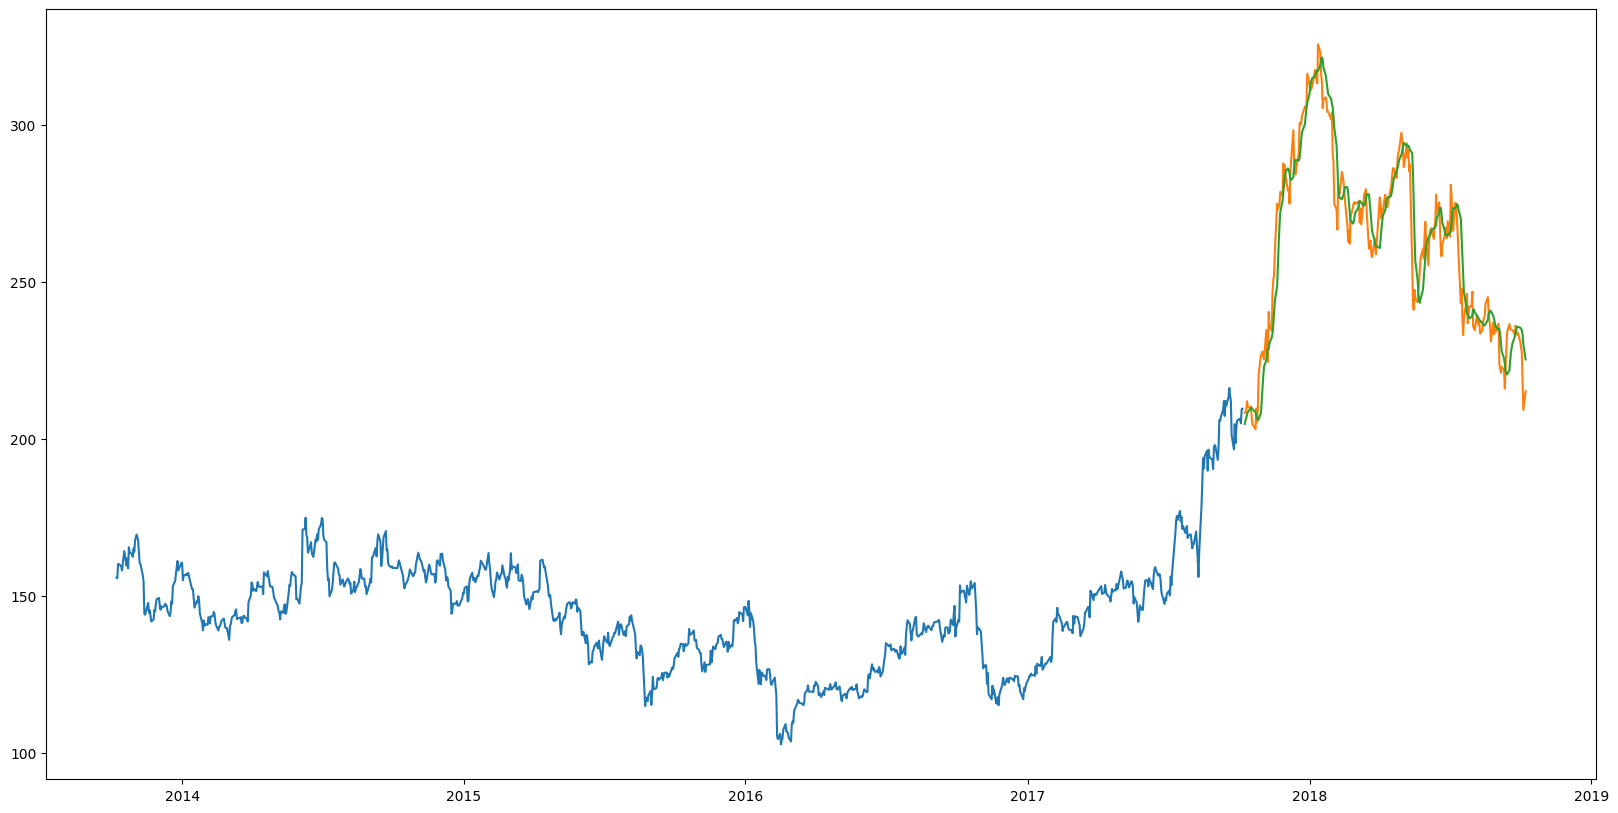

In [44]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])